# Statistics (b)

## Bayesian Regression

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
plt.style.use('seaborn')
plt.rc('font',family='serif')
np.random.seed(1000)
%matplotlib inline

In [3]:
import arviz as az
az.style.use("arviz-darkgrid")

### Introductory Example

In [4]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2

In [5]:
reg = np.polyfit(x, y, 1)

In [6]:
reg

array([2.03384161, 3.77649234])

Text(0, 0.5, 'y')

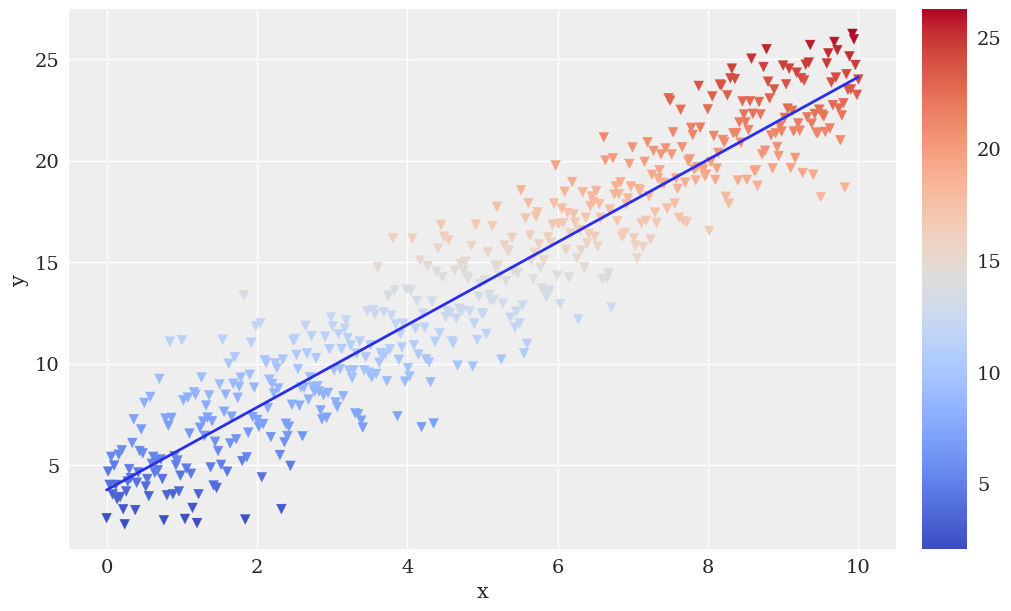

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
# plt.savefig('../../images/ch13/stat_15.png');

In [8]:
import warnings; warnings.simplefilter('ignore')

In [9]:
import pymc3 as pm

In [12]:
%%time
with pm.Model() as model:
    # model
    alpha = pm.Normal('alpha', mu=0, sd=20)  # Defines the priors
    beta = pm.Normal('beta', mu=0, sd=10)  # Defines the priors 
    sigma = pm.Uniform('sigma', lower=0, upper=10)  # Defines the priors
    y_est = alpha + beta * x    # Specifies the linear regression
    likelihood = pm.Normal('y', mu=y_est, sd=sigma,
                           observed=y)   # Defines the likelihood.
    
    # inference
    start = pm.find_MAP()    # Finds the starting value by optimization.
    step = pm.NUTS()    #  Instantiates the MCMC algorithm.
    trace = pm.sample(100, tune=1000, start=start, progressbar=True)  #  Instantiates the MCMC algorithm.


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.900338281023947, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9030490171888702, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 10.1 s, sys: 1.06 s, total: 11.2 s
Wall time: 1min 4s


In [13]:
pm.summary(trace)   # Shows summary statistics from samplings.

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.754,0.174,3.433,4.070,0.018,0.013,93.0,72.0,1.00
beta,2.037,0.030,1.985,2.099,0.003,0.002,99.0,122.0,1.01
sigma,2.021,0.064,1.913,2.142,0.007,0.005,98.0,119.0,1.02


In [14]:
trace

<MultiTrace: 2 chains, 100 iterations, 4 variables>

In [15]:
trace[0]

{'alpha': 3.659149672711724,
 'beta': 2.0430044669672807,
 'sigma': 1.9752470811426832,
 'sigma_interval__': -1.4018373847104262}

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


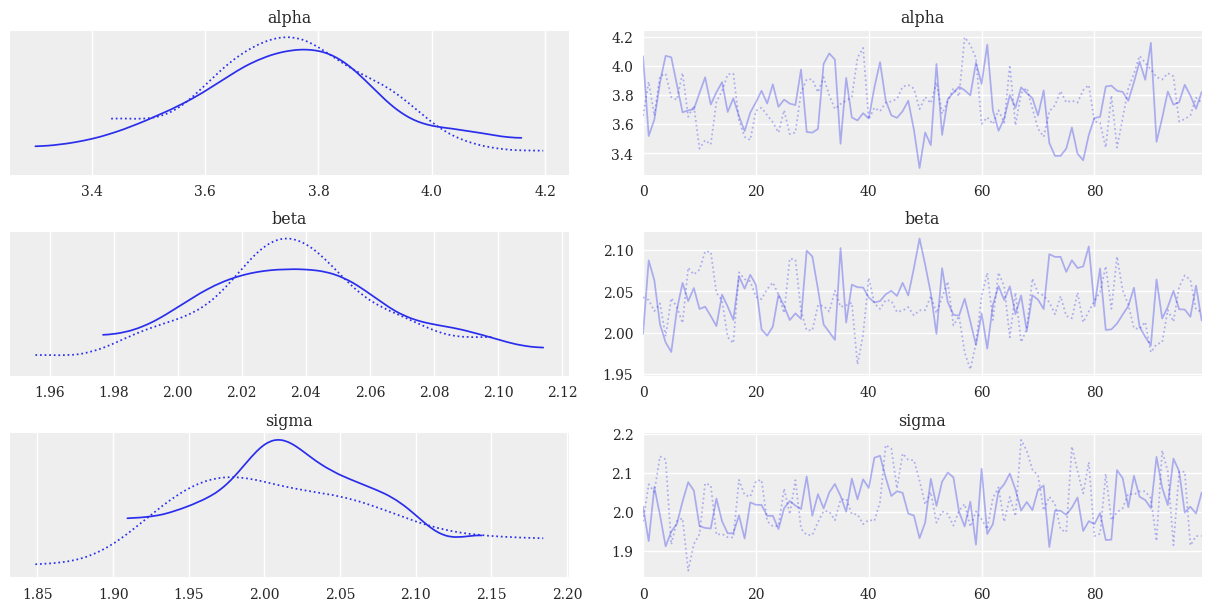

In [16]:
pm.traceplot(trace, lines={'alpha': 4, 'beta': 2, 'sigma': 2});
# plt.savefig('../../images/ch13/stat_16.png');

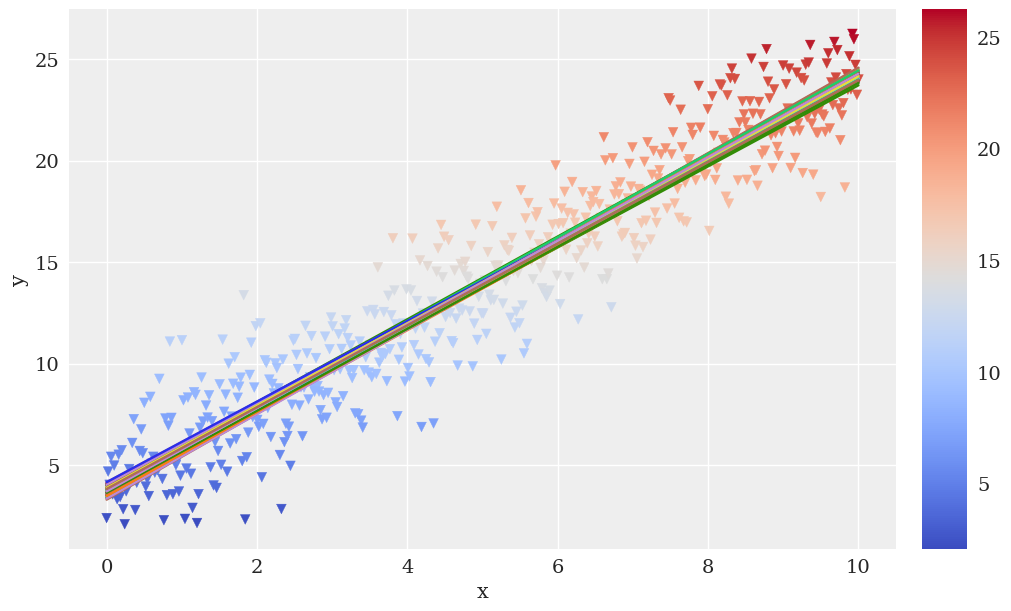

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x)  
# plt.savefig('../../images/ch13/stat_17.png');

In [22]:
%%time
with pm.Model() as model:
    # model
    alpha = pm.Normal('alpha', mu=0, sd=20)  # Defines the priors
    beta = pm.Normal('beta', mu=0, sd=10)  # Defines the priors 
    sigma = pm.Uniform('sigma', lower=0, upper=10)  # Defines the priors
    y_est = alpha + beta * x    # Specifies the linear regression
    likelihood = pm.Normal('y', mu=y_est, sd=sigma,
                           observed=y)   # Defines the likelihood.
    
    # inference
    trace = pm.sample()  #  Instantiates the MCMC algorithm.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8909400306450687, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 8.03 s, sys: 152 ms, total: 8.18 s
Wall time: 8.17 s


In [23]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.774,0.186,3.433,4.122,0.006,0.004,976.0,1024.0,1.00
beta,2.035,0.032,1.978,2.095,0.001,0.001,941.0,910.0,1.00
sigma,2.009,0.064,1.892,2.125,0.002,0.001,1162.0,1036.0,1.01


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


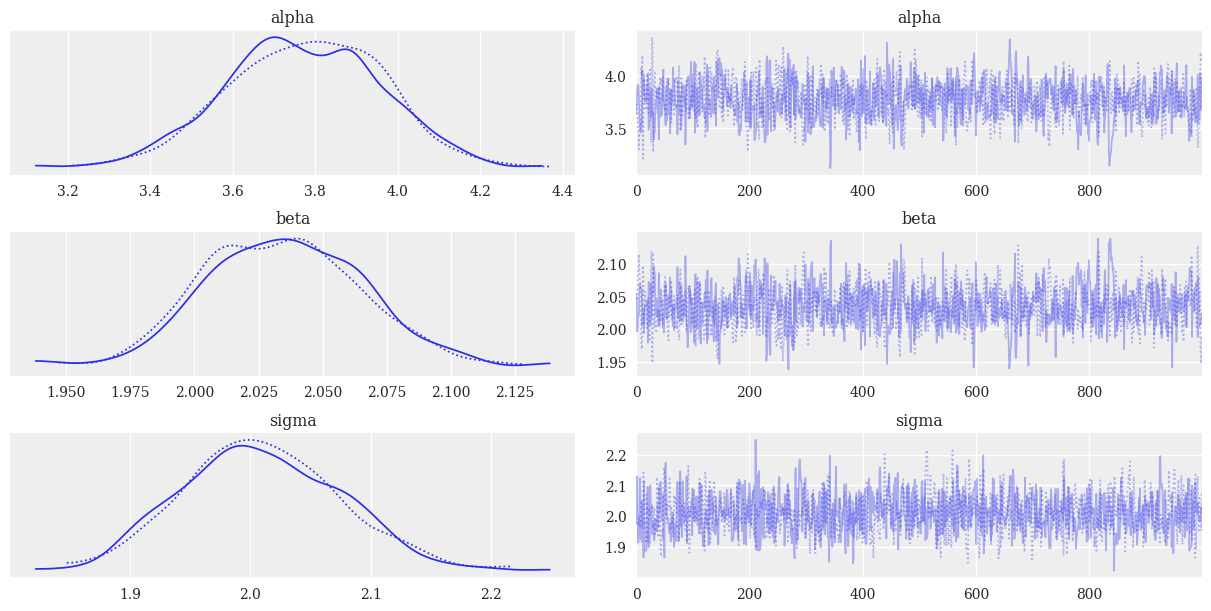

In [25]:
pm.traceplot(trace, lines={'alpha': 4, 'beta': 2, 'sigma': 2});
# plt.savefig('../../images/ch13/stat_16.png');

### Two Financial Instruments

In [26]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [27]:
data = raw[['GDX', 'GLD']].dropna()

In [28]:
data

,GDX,GLD
Date,,
2010-01-04,47.71,109.80
2010-01-05,48.17,109.70
2010-01-06,49.34,111.51
2010-01-07,49.10,110.82
2010-01-08,49.84,111.37
...,...,...
2018-06-25,22.01,119.89
2018-06-26,21.95,119.26
2018-06-27,21.81,118.58


In [29]:
data.iloc[0]

GDX     47.71
GLD    109.80
Name: 2010-01-04 00:00:00, dtype: float64

In [30]:
data = data / data.iloc[0]  

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDX     2138 non-null   float64
 1   GLD     2138 non-null   float64
dtypes: float64(2)
memory usage: 50.1 KB


In [32]:
data.iloc[-1] / data.iloc[0] - 1  

GDX   -0.532383
GLD    0.080601
dtype: float64

In [33]:
data.corr()  

,GDX,GLD
GDX,1.00000,0.71539
GLD,0.71539,1.00000


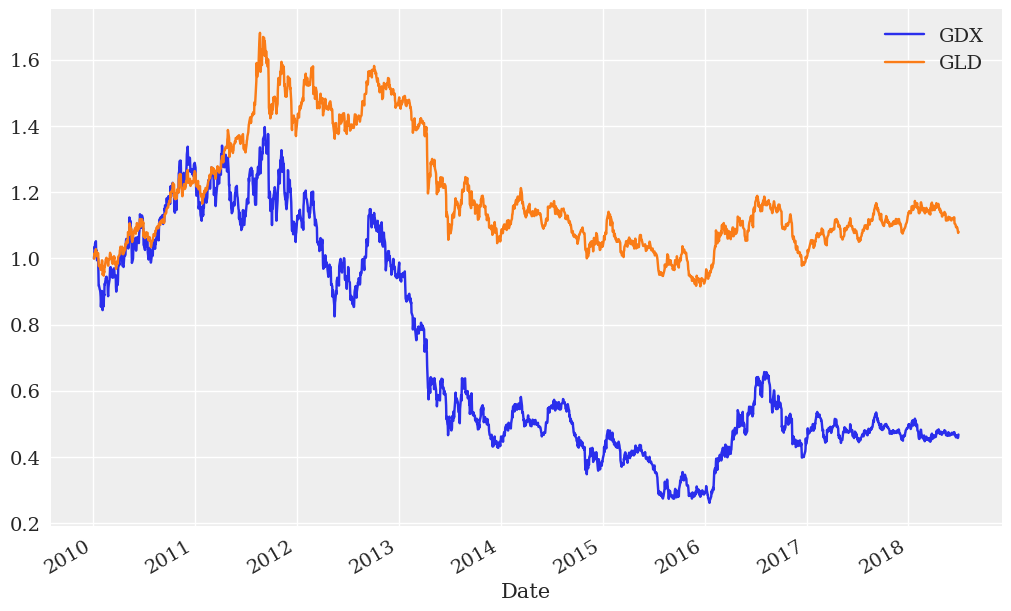

In [34]:
data.plot(figsize=(10, 6));
# plt.savefig('../../images/ch13/stat_18.png');

In [35]:
data.index[:3]

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06'], dtype='datetime64[ns]', name='Date', freq=None)

In [36]:
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())  
mpl_dates[:3]

array([733776., 733777., 733778.])

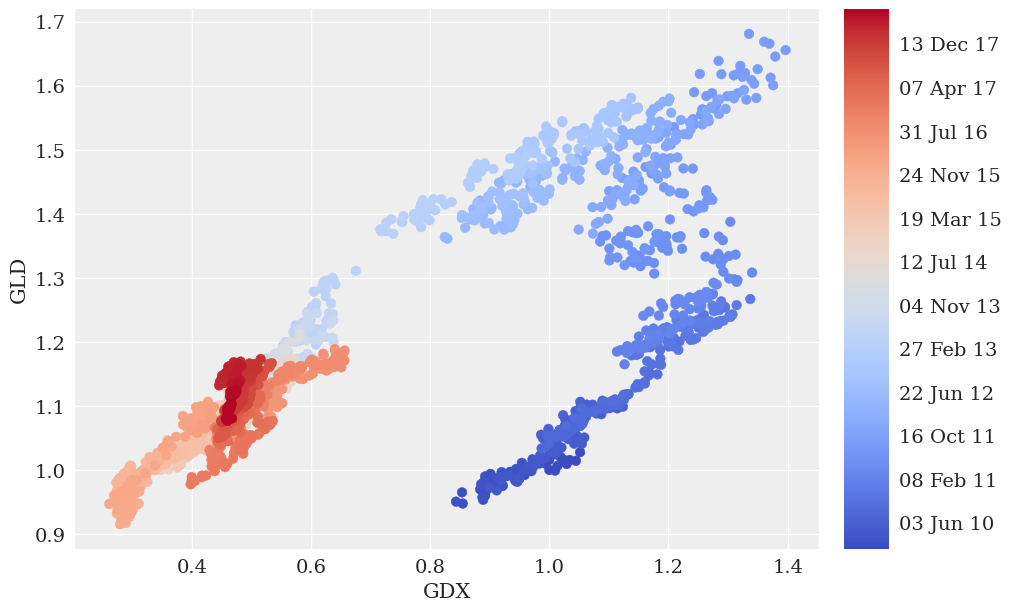

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
            marker='o', cmap='coolwarm')
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'));  
# plt.savefig('../../images/ch13/stat_19.png');

In [39]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    y_est = alpha + beta * data['GDX'].values
    
    likelihood = pm.Normal('GLD', mu=y_est, sd=sigma,
                           observed=data['GLD'].values)
    

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


In [40]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.914,0.007,0.902,0.926,0.0,0.0,682.0,701.0,1.0
beta,0.385,0.008,0.370,0.401,0.0,0.0,648.0,767.0,1.0
sigma,0.120,0.002,0.116,0.123,0.0,0.0,992.0,857.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


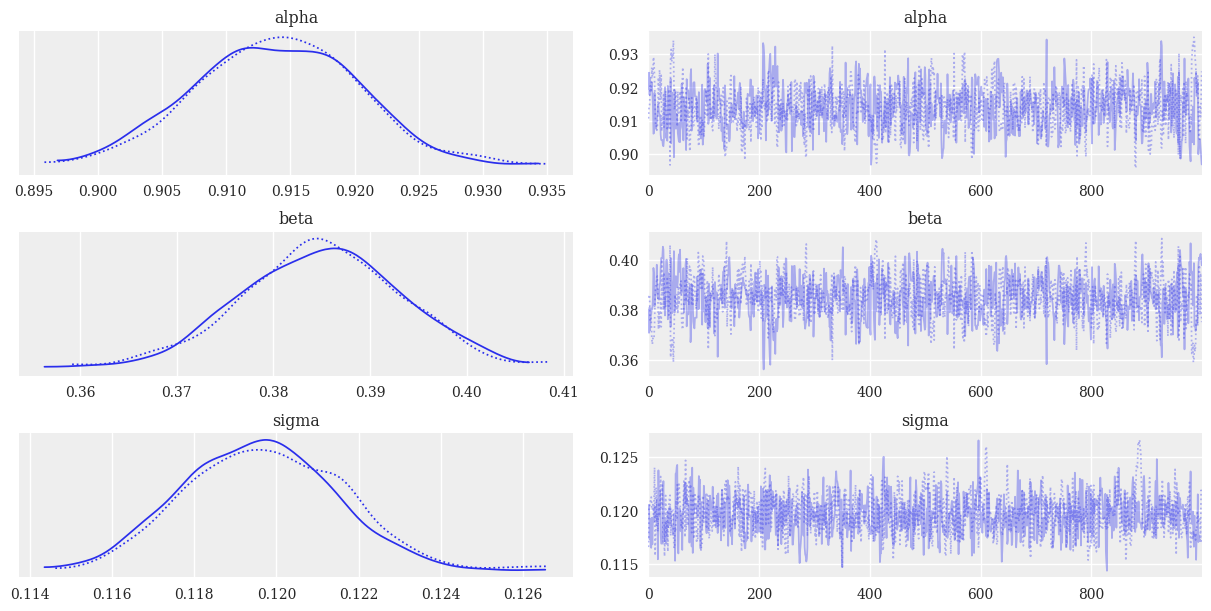

In [41]:
fig = az.plot_trace(trace)
# plt.savefig('../../images/ch13/stat_20.png');

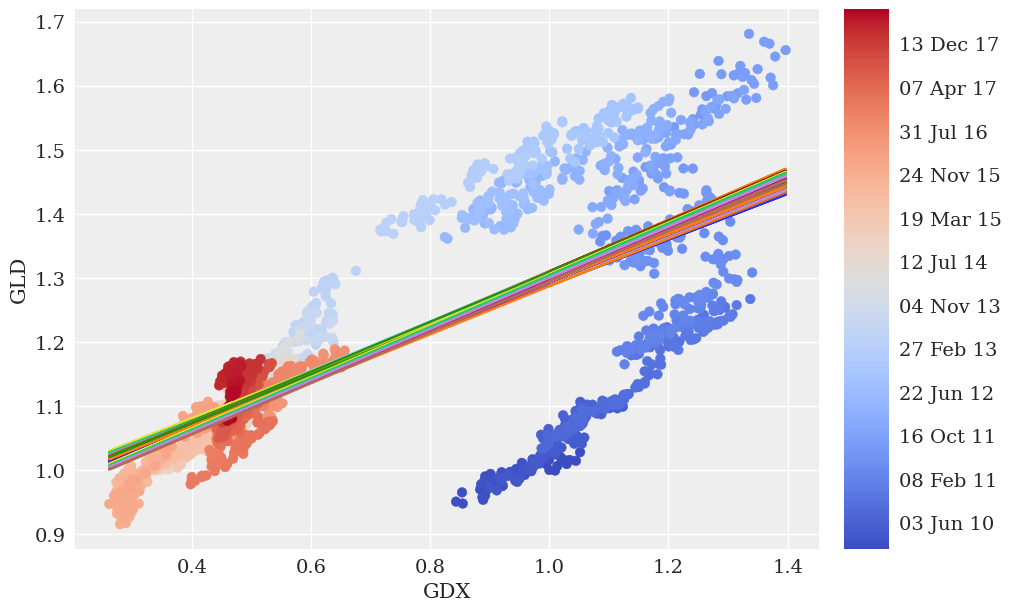

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
marker='o', cmap='coolwarm')
plt.xlabel('GDX')
plt.ylabel('GLD')
for i in range(len(trace)):
  plt.plot(data['GDX'],
           trace['alpha'][i] + trace['beta'][i] * data['GDX'])
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
          format=mpl.dates.DateFormatter('%d %b %y'));

### Updating Estimates over Time

In [44]:
from pymc3.distributions.timeseries import GaussianRandomWalk

In [45]:
subsample_alpha = 50
subsample_beta = 50

In [46]:
shape=int(len(data) / subsample_alpha)
shape

42

In [47]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sig_alpha', 1. / .02, testval=.1)  
    sigma_beta = pm.Exponential('sig_beta', 1. / .02, testval=.1)  
    alpha = GaussianRandomWalk('alpha', sigma_alpha ** -2,
                        shape=int(len(data) / subsample_alpha))  
    beta = GaussianRandomWalk('beta', sigma_beta ** -2,
                        shape=int(len(data) / subsample_beta))  
    alpha_r = np.repeat(alpha, subsample_alpha)  
    beta_r = np.repeat(beta, subsample_beta)  
    regression = alpha_r + beta_r * data['GDX'].values[:2100]  
    sd = pm.Uniform('sd', 0, 20)  
    likelihood = pm.Normal('GLD', mu=regression, sd=sd,
                           observed=data['GLD'].values[:2100])  

In [49]:
%%time
with model_randomwalk:
    trace_rw = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta, alpha, sig_beta, sig_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 211 seconds.


CPU times: user 3min 39s, sys: 2.17 s, total: 3min 41s
Wall time: 3min 57s


In [50]:
pm.summary(trace_rw).head()

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.671,0.041,0.595,0.749,0.001,0.000,4854.0,1339.0,1.0
alpha[1],0.424,0.040,0.351,0.499,0.001,0.001,2999.0,1375.0,1.0
alpha[2],0.456,0.061,0.332,0.564,0.001,0.001,4031.0,1138.0,1.0
alpha[3],0.269,0.045,0.175,0.349,0.001,0.000,4515.0,1374.0,1.0
alpha[4],0.652,0.054,0.553,0.753,0.001,0.001,3659.0,1449.0,1.0


In [51]:
sh = np.shape(trace_rw['alpha']) 
sh

(2000, 42)

In [52]:
part_dates = np.linspace(min(mpl_dates), max(mpl_dates), sh[1])    

In [53]:
index = [dt.datetime.fromordinal(int(date)) for date in part_dates]
index  

[datetime.datetime(2010, 1, 4, 0, 0),
 datetime.datetime(2010, 3, 20, 0, 0),
 datetime.datetime(2010, 6, 4, 0, 0),
 datetime.datetime(2010, 8, 18, 0, 0),
 datetime.datetime(2010, 11, 2, 0, 0),
 datetime.datetime(2011, 1, 16, 0, 0),
 datetime.datetime(2011, 4, 2, 0, 0),
 datetime.datetime(2011, 6, 16, 0, 0),
 datetime.datetime(2011, 8, 31, 0, 0),
 datetime.datetime(2011, 11, 15, 0, 0),
 datetime.datetime(2012, 1, 29, 0, 0),
 datetime.datetime(2012, 4, 14, 0, 0),
 datetime.datetime(2012, 6, 28, 0, 0),
 datetime.datetime(2012, 9, 12, 0, 0),
 datetime.datetime(2012, 11, 26, 0, 0),
 datetime.datetime(2013, 2, 10, 0, 0),
 datetime.datetime(2013, 4, 26, 0, 0),
 datetime.datetime(2013, 7, 11, 0, 0),
 datetime.datetime(2013, 9, 25, 0, 0),
 datetime.datetime(2013, 12, 9, 0, 0),
 datetime.datetime(2014, 2, 23, 0, 0),
 datetime.datetime(2014, 5, 9, 0, 0),
 datetime.datetime(2014, 7, 24, 0, 0),
 datetime.datetime(2014, 10, 7, 0, 0),
 datetime.datetime(2014, 12, 22, 0, 0),
 datetime.datetime(2015, 3

In [54]:
alpha = {'alpha_%i' % i: v for i, v in enumerate(trace_rw['alpha']) if i < 20} 

In [55]:
alpha

{'alpha_0': array([0.71343775, 0.43057139, 0.51235635, 0.27241043, 0.60557557,
        0.57342578, 1.18894675, 0.85975206, 0.4994894 , 0.56191618,
        0.37690295, 0.98995315, 1.04878127, 0.81043746, 1.14813952,
        0.99059877, 0.74747436, 0.5593238 , 0.78531759, 0.66526417,
        0.66502484, 0.71576319, 0.81750515, 0.72855686, 0.77928877,
        0.73852517, 0.79583911, 0.7537078 , 0.7652984 , 0.55458303,
        0.66055354, 0.96599312, 0.75940468, 0.90460335, 0.61266314,
        0.65407522, 0.69757466, 0.63701648, 0.61032812, 0.7149145 ,
        0.81193163, 1.00936477]),
 'alpha_1': array([0.62520551, 0.43921153, 0.39241781, 0.27248891, 0.68376564,
        0.62661415, 1.16224879, 0.73044758, 0.45491488, 0.5165221 ,
        0.24237535, 1.05210666, 1.20343693, 0.79371335, 1.22660269,
        1.05296654, 0.71407798, 0.59110686, 0.804381  , 0.6538259 ,
        0.64291016, 0.66751031, 0.8146624 , 0.74046147, 0.70751322,
        0.64050374, 0.68167554, 0.75820496, 0.71063031, 0.52

In [57]:
beta = {'beta_%i' % i: v for i, v in
          enumerate(trace_rw['beta']) if i < 20}  

In [58]:
df_alpha = pd.DataFrame(alpha, index=index)

In [59]:
df_beta = pd.DataFrame(beta, index=index) 

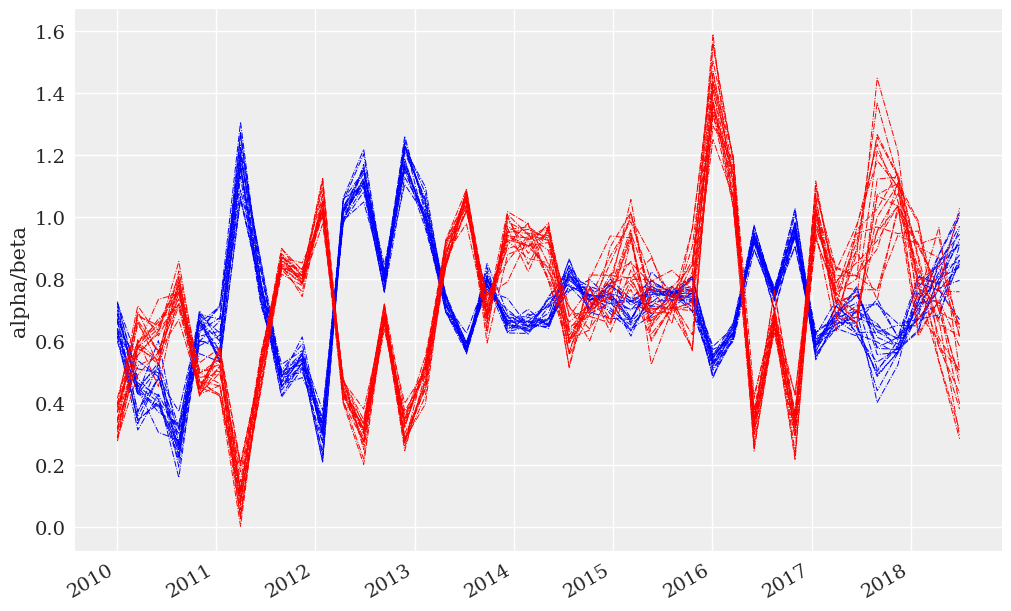

In [60]:
ax = df_alpha.plot(color='b', style='-.', legend=False,
        lw=0.7, figsize=(10, 6))
df_beta.plot(color='r', style='-.', legend=False,
        lw=0.7, ax=ax)
plt.ylabel('alpha/beta');

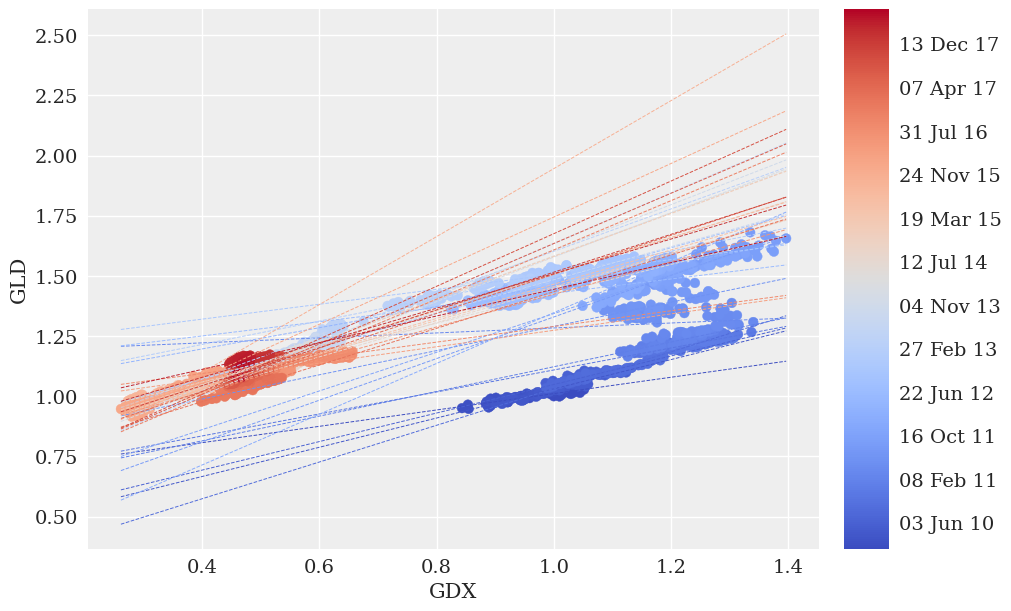

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
            marker='o', cmap='coolwarm')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'))
plt.xlabel('GDX')
plt.ylabel('GLD')
x = np.linspace(min(data['GDX']), max(data['GDX']))
for i in range(sh[1]):  
    alpha_rw = np.mean(trace_rw['alpha'].T[i])
    beta_rw = np.mean(trace_rw['beta'].T[i])
    plt.plot(x, alpha_rw + beta_rw * x, '--', lw=0.7,
            color=plt.cm.coolwarm(i / sh[1]))
# plt.savefig('../../images/ch13/stat_23.png');

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>